# k-NN with Distance Metrics - Customer Segmentation Lab:

## Business Scenario

You work as a data scientist for RetailIQ, an e-commerce analytics company that helps online retailers better understand their customers. One of your clients, an online fashion retailer, wants to segment their customer base to create more targeted marketing campaigns.

Your task is to develop a customer segmentation model using k-Nearest Neighbors with various distance metrics. The client has provided data on customer purchasing behavior, demographics, and engagement metrics.

They've already identified five customer segments in their previous marketing research:
- Segment 0: Occasional Shoppers (low frequency, low value)
- Segment 1: Loyal Regular Shoppers (high frequency, moderate value)
- Segment 2: High-Value Enthusiasts (high frequency, high value)
- Segment 3: Big Spenders (low frequency, high value)
- Segment 4: New Customers (recent first purchase)

The goal is to build a model that can accurately classify new customers into these segments based on their behavior and attributes, so that marketing strategies can be personalized for each segment.

## The Process

By the end of this lab, you will have:
1. Analyzed the dataset to understand the characteristics of customer features
2. Preprocessed the data appropriately for distance calculations
3. Implemented k-NN with different distance metrics
4. Evaluated and compared the performance of each metric
5. Tuned and optimized the best-performing model
6. Evaluated the performance of the final model and best distance metric


## Step 0: Setup - Import Libraries and Load Data

First, let's import all the necessary libraries and load our dataset.

In [1]:
# CodeGrade step0
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

### Loading and exploring the dataset

The dataset contains customer information and a target variable 'segment' indicating their assigned segment (0-4).

In [3]:
# CodeGrade step0
# Load the dataset
customer_data = pd.read_csv('retail_customer_data.csv')

In [4]:
# Run this cell without changes
# Display basic information about the dataset
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          1000 non-null   float64
 1   frequency        1000 non-null   int64  
 2   monetary         1000 non-null   float64
 3   tenure           1000 non-null   float64
 4   website_visits   1000 non-null   int64  
 5   time_spent_mins  1000 non-null   float64
 6   wishlist_items   1000 non-null   int64  
 7   cart_abandons    1000 non-null   int64  
 8   age              1000 non-null   int64  
 9   income           1000 non-null   float64
 10  segment          1000 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 86.1 KB


In [5]:
# Run this cell without changes
# Check the first few rows of the dataset
customer_data.head()

,recency,frequency,monetary,tenure,website_visits,time_spent_mins,wishlist_items,cart_abandons,age,income,segment
0,51.323182,3,8.24,23.437422,3,1.18,0,0,18,31700.0,0
1,63.590512,1,25.41,4.965348,1,0.82,0,1,33,66600.0,0
2,46.751386,2,21.68,22.360815,3,1.98,1,1,18,50500.0,0
3,40.771332,1,16.84,41.214239,3,0.79,1,0,30,51400.0,0
4,38.829267,2,23.41,18.509466,3,0.90,2,1,35,60200.0,0


In [6]:
# Run this cell without changes
# Check the distribution of the target variable
customer_data['segment'].value_counts(normalize=True)

segment
4    0.30
0    0.25
1    0.20
2    0.15
3    0.10
Name: proportion, dtype: float64

In [7]:
# Run this cell without changes
# Check basic statistics of the dataset
customer_data.describe()

,recency,frequency,monetary,tenure,website_visits,time_spent_mins,wishlist_items,cart_abandons,age,income,segment
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000
mean,24.227014,8.699000,109.435840,23.393298,10.393000,6.577840,5.146000,1.736000,37.74200,84898.600000,2.00000
std,22.649354,11.552396,160.569538,21.883794,9.472396,4.771991,5.240816,1.477324,14.95711,57948.597204,1.58193
min,0.521351,0.000000,7.700000,0.000000,1.000000,0.400000,0.000000,0.000000,18.00000,20000.000000,0.00000
25%,8.038591,1.000000,28.272500,1.096756,3.000000,2.820000,1.000000,1.000000,26.00000,45525.000000,0.75000
50%,16.280167,2.000000,50.105000,19.860014,8.000000,5.815000,4.000000,1.000000,36.00000,67000.000000,2.00000
75%,32.048267,15.000000,100.165000,37.441203,14.000000,8.915000,8.000000,3.000000,46.00000,108600.000000,4.00000
max,116.759071,55.000000,1107.940000,101.556534,54.000000,28.260000,28.000000,7.000000,90.00000,368200.000000,4.00000


## Part 1: Analyzing Dataset Characteristics

Before selecting a distance metric, we need to understand the characteristics of our data. Let's look at feature distributions and correlations.

### Feature Distributions
Analyzing feature distributions will help us understand if we need to standardize our data before applying distance metrics.

<Figure size 1500x1000 with 0 Axes>

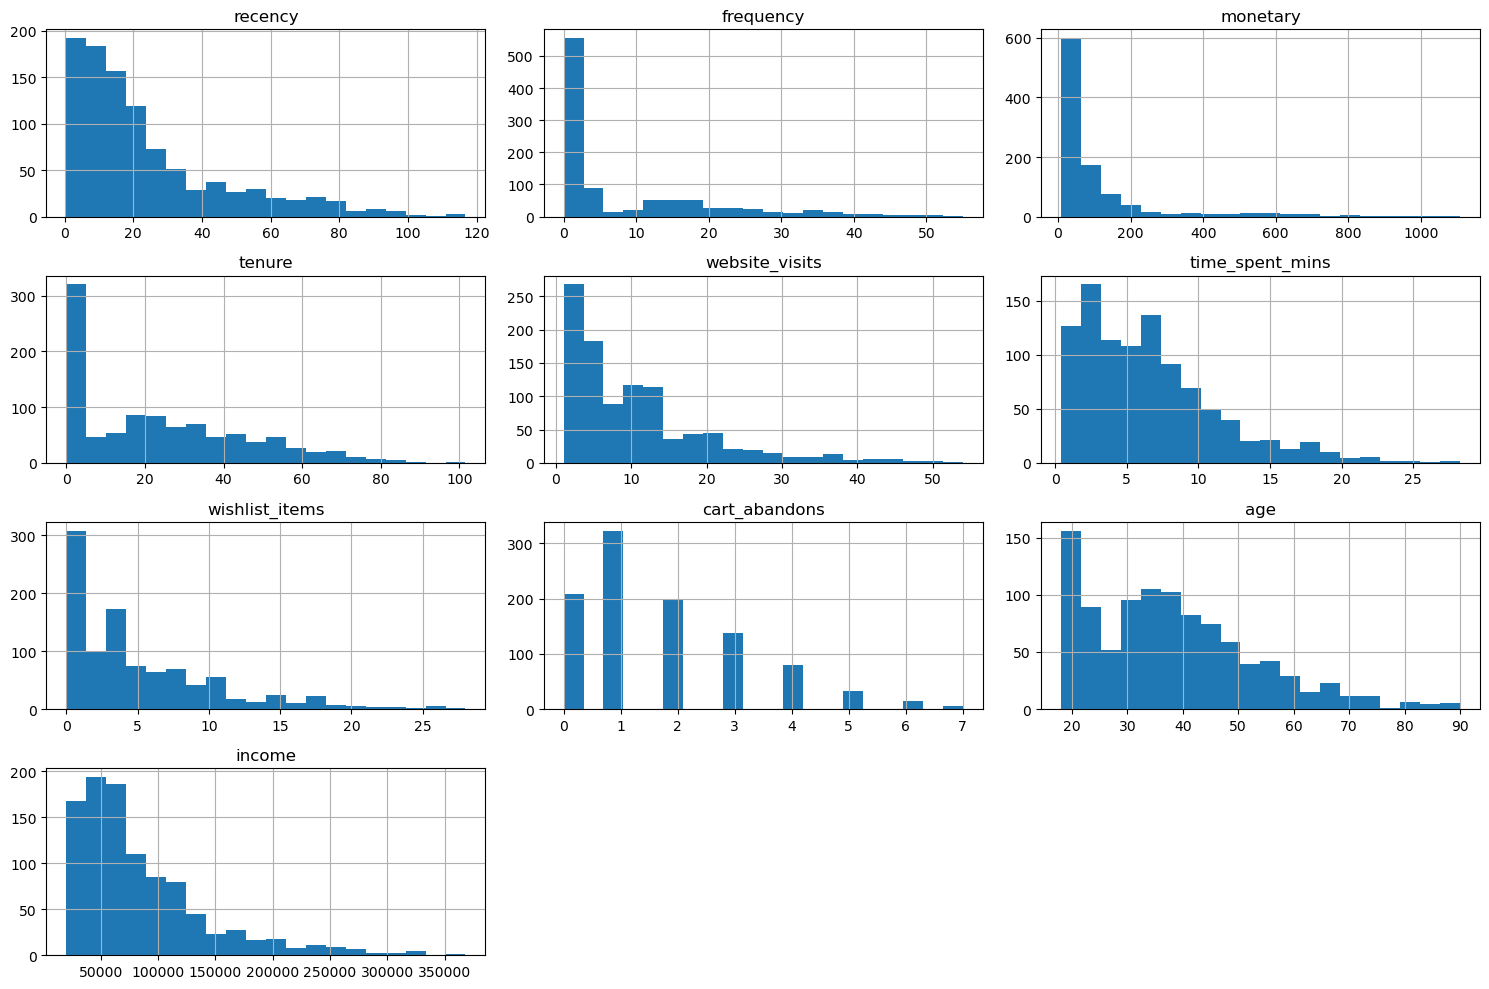

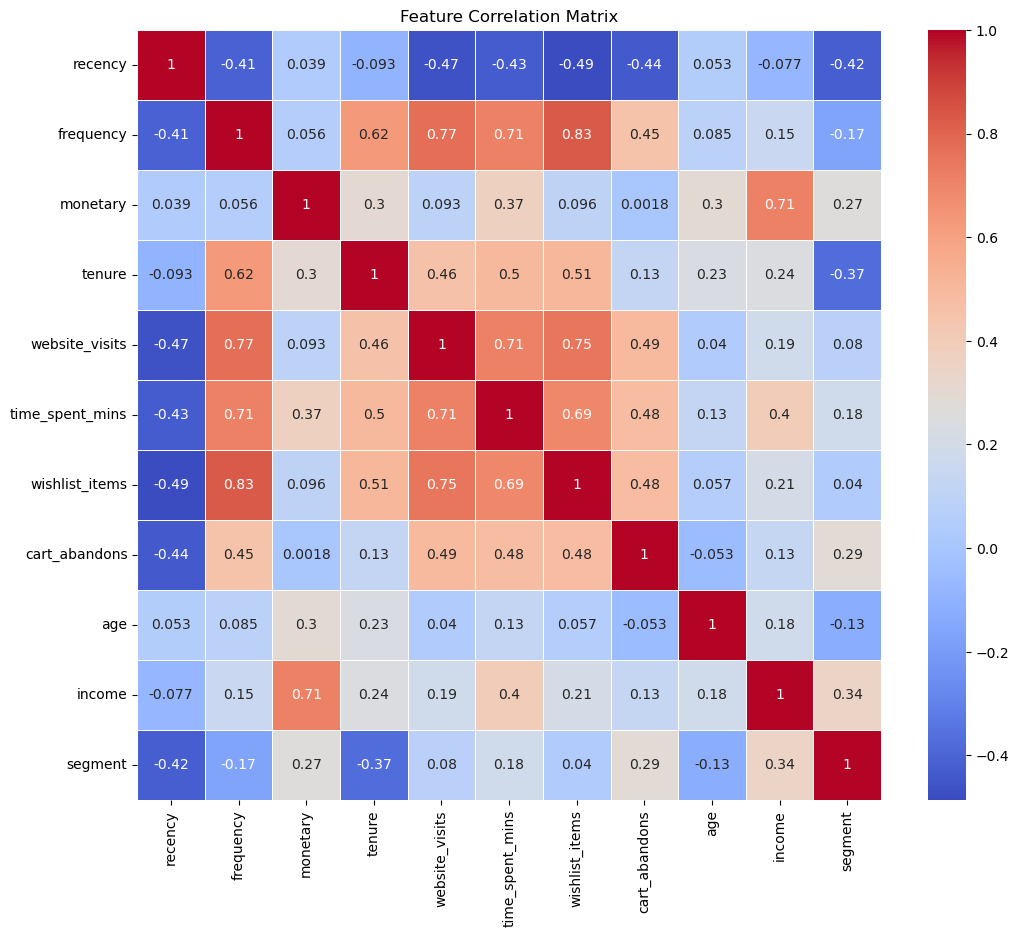

In [8]:
# CodeGrade step1
# Create histograms of all features to observe their distributions
# Select all numeric columns except the target
numeric_columns = customer_data.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('segment')  

# Plot histograms
plt.figure(figsize=(15, 10))
customer_data[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show();

# Create a correlation matrix to identify feature relationships - use the full dataframe including segment
correlation_matrix = customer_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show();

### Data Characteristics Analysis

Based on the histograms and correlation matrix above, consider how these questions help you:

1. Do you observe any features with significantly different scales? What impact would this have on distance calculations?

2. Are there correlations between features? Which distance metric might be more appropriate for correlated features?

3. Based on your analysis, which preprocessing steps would you recommend before applying k-NN with distance metrics?

## Part 2: Data Preprocessing

Now, let's prepare our data for k-NN modeling, applying the preprocessing steps you identified as necessary.

In [9]:
# CodeGrade step2
# Prepare features (X) and target (y)
X = customer_data[numeric_columns].copy()
y = customer_data['segment'].copy()

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [10]:
# Run this cell without changes to display results
# Display a comparison of original vs. scaled data for the first sample
print("Original first sample:")
print(X_train.iloc[0].values[:5], "...")
print("\nScaled first sample:")
print(X_train_scaled[0][:5], "...")

Original first sample:
[75.1963513   2.         28.17       21.85588913  1.        ] ...

Scaled first sample:
[ 2.18178794 -0.58374481 -0.50719398 -0.07893169 -0.99262866] ...


## Part 3: Implementing k-NN with Different Distance Metrics

Now, let's implement k-NN with various distance metrics and evaluate their performance using cross-validation accuracy.

In [12]:
# CodeGrade step3
# Distance metrics to test
metrics = ['euclidean', 'manhattan', 'chebyshev']
k_value = 5

# Dictionary to store results
results = {}

# Loop through list of metrics
for m in metrics:
    # Create and evaluate model with different metrics and k=5
    knn = KNeighborsClassifier(n_neighbors=k_value, metric=m, weights='uniform')
    # Get cross val scores for model
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # Store the mean of cv scores as value and metric name as key in results dictionary
    results[m] = cv_scores.mean()
    
best_metric = max(results, key=results.get)

In [13]:
# Run this cell without changes
# Find the best metric
print(results)
print(f"\nBest metric: {best_metric} with accuracy: {results[best_metric]:.4f}")

{'euclidean': 0.9946666666666666, 'manhattan': 0.9893333333333333, 'chebyshev': 0.984}

Best metric: euclidean with accuracy: 0.9947


## Part 4: Implementing Mahalanobis Distance

Mahalanobis distance is particularly useful for datasets with correlated features. Let's implement it separately and compare its performance to the other metrics we tested.

In [15]:
# CodeGrade step4
# Calculate covariance matrix from the training data
cov = np.cov(X_train_scaled, rowvar=False)
inv_cov = np.linalg.inv(cov)

# Implement k-NN with Mahalanobis distance and k=5
knn_mahalanobis = KNeighborsClassifier(
    n_neighbors=5,
    metric='mahalanobis',
    metric_params={'VI': inv_cov},
    weights='uniform'
)

# Evaluate performance via cross validation
cv_scores_mahalanobis = cross_val_score(knn_mahalanobis, X_train_scaled, y_train, cv=5, scoring='accuracy')
results['mahalanobis'] = cv_scores_mahalanobis.mean()

In [16]:
# Run this cell without changes
print(f"Average CV accuracy with Mahalanobis: {cv_scores_mahalanobis.mean():.4f}")

# Update best metric if necessary
if results['mahalanobis'] > results[best_metric]:
    best_metric = 'mahalanobis'
    print(f"New best metric: {best_metric} with accuracy: {results[best_metric]:.4f}")

Average CV accuracy with Mahalanobis: 0.9373


## Part 5: Hyperparameter Tuning

Now, let's optimize our model by finding the best k value and weighting scheme for the top-performing distance metric.

Use the following information for your grid search:
- 'n_neighbors': [1, 3, 5, 7, 9]
- 'weights': ['uniform', 'distance']

In [17]:
# CodeGrade step5
# Define parameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Create base model with best metric
if best_metric == 'mahalanobis':
    base_model = KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': inv_cov})
else:
    base_model = KNeighborsClassifier(metric=best_metric)

# Initialize and run grid search
grid_search =  GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

grid_search.fit(X_train_scaled, y_train)

# Get best parameters and accuracy
best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

Best parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9960


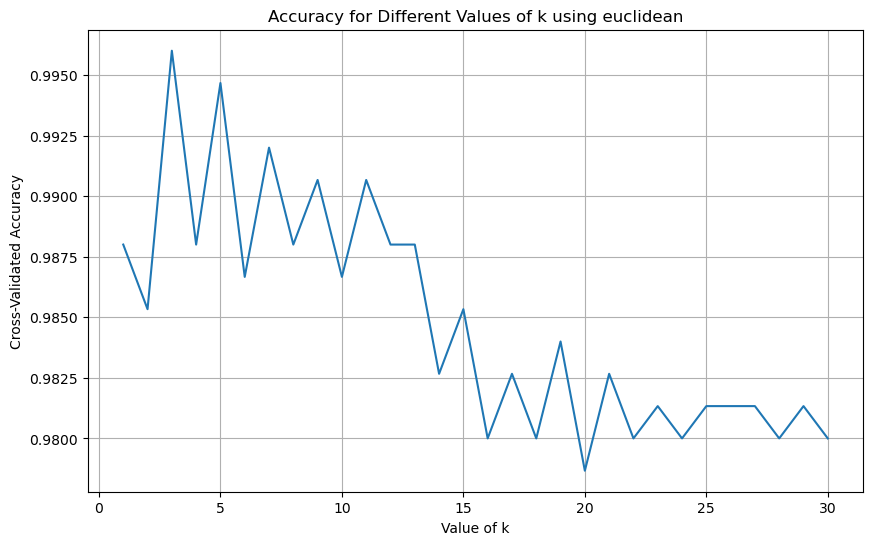

In [18]:
# Run this cell without changes
# Visualization of accuracy for different k values
# This helps us understand the relationship between k and model performance
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Accuracy for Different Values of k using {best_metric}')
plt.grid(True)
plt.show()

## Part 6: Final Model Evaluation

Let's build our final model with the optimized parameters and evaluate it on the test set.

In [19]:
# CodeGrade step6
# Build final model with best parameters
final_model = grid_search.best_estimator_
final_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = final_model.predict(X_test_scaled)


# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

Test set accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        75

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



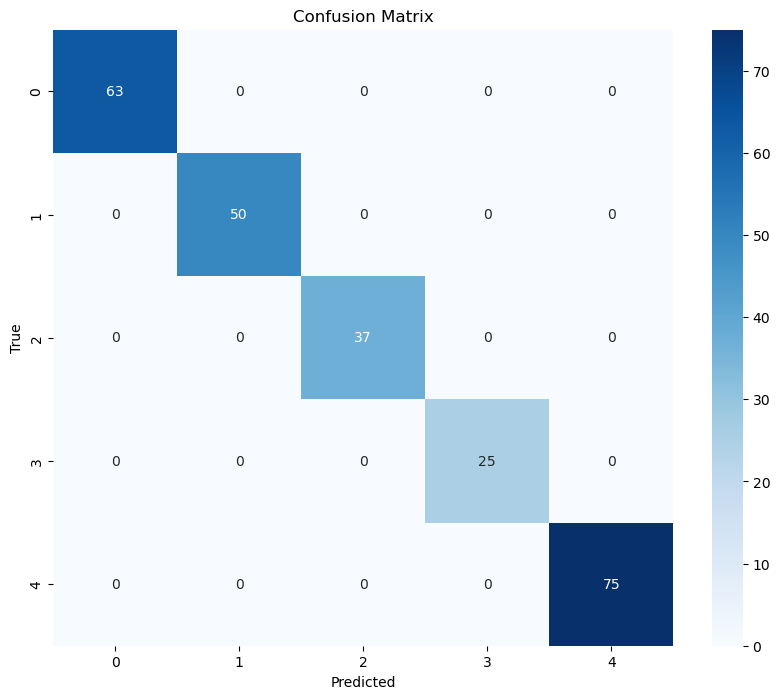

In [20]:
# Run this cell without changes
print(f"Test set accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()